In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, InputLayer
import random
import os
import math
import pylab as p
import seaborn as sns
from datetime import datetime, timedelta
import string

In [26]:
file_path_volts1 = r".\dataset\H1\Tagged_Training_12_27_1356595201\LF1V.csv"
file_path_amps1 = r".\dataset\H1\Tagged_Training_12_27_1356595201\LF1I.csv"
file_path_time_ticks1 = r".\dataset\H1\Tagged_Training_12_27_1356595201\TimeTicks1.csv"

file_path_volts2 = r".\dataset\H1\Tagged_Training_12_27_1356595201\LF2V.csv"
file_path_amps2 = r".\dataset\H1\Tagged_Training_12_27_1356595201\LF2I.csv"
file_path_time_ticks2 = r".\dataset\H1\Tagged_Training_12_27_1356595201\TimeTicks2.csv"

file_path_tagging_info = r".\dataset\H1\Tagged_Training_12_27_1356595201\TaggingInfo.csv"

LF1V = pd.read_csv(file_path_volts1)
LF1I = pd.read_csv(file_path_amps1)
time_ticks1 = pd.read_csv(file_path_time_ticks1)

LF2V = pd.read_csv(file_path_volts2)
LF2I = pd.read_csv(file_path_amps2)
time_ticks2 = pd.read_csv(file_path_time_ticks2)

tagging_info = pd.read_csv(file_path_tagging_info)

In [27]:
LF1V = np.array(LF1V)
LF1I = np.array(LF1I)
LF1V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1V])
LF1I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1I])

LF2V = np.array(LF2V)
LF2I = np.array(LF2I)
LF2V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2V])
LF2I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2I])

In [28]:
L1_P = LF1V * np.conjugate(LF1I)
L2_P = LF2V * np.conjugate(LF2I)

L1_ComplexPower = np.sum(L1_P, axis=1)
L2_ComplexPower = np.sum(L2_P, axis=1)

L1_real = np.real(L1_ComplexPower)
L1_imag = np.imag(L1_ComplexPower)
L1_app = np.abs(L1_ComplexPower)

L2_real = np.real(L2_ComplexPower)
L2_imag = np.imag(L2_ComplexPower)
L2_app = np.abs(L2_ComplexPower)

L1_Pf = np.cos(np.angle(L1_P[:, 0]))
L2_Pf = np.cos(np.angle(L2_P[:, 0]))

L1_actual_power = L1_real * L1_Pf
L2_actual_power = L2_real * L2_Pf

# power = L1_actual_power + L2_actual_power[:len(L1_actual_power)]

In [106]:
time_ticks1_datetime = pd.to_datetime(time_ticks1.iloc[:, 0], unit='s')
time_ticks1_np = np.array(time_ticks1)
TS1_real = np.array(time_ticks1_datetime)

time_ticks2_datetime = pd.to_datetime(time_ticks2.iloc[:, 0], unit='s')
time_ticks2_np = np.array(time_ticks2)
TS2_real = np.array(time_ticks2_datetime)

# Event detection

### Smooth the data a little bit

In [30]:
def moving_average(array, window):
    moving_avg = np.convolve(array, np.ones(window) / window, mode='valid')
    return moving_avg

In [90]:
smooth_data = moving_average(L2_actual_power, 7)
print(smooth_data)

[141.83184462 141.79148439 141.73965013 ...  90.23029547  90.41793376
  90.47421202]


### Normalize the data

In [91]:
def normalize(array):
    min_val = np.min(array)
    max_val = np.max(array)
    normalized_array = (array - min_val) / (max_val - min_val)
    return normalized_array

In [92]:
normalized_data = normalize(smooth_data)
print(normalized_data)

[0.02199703 0.02198139 0.02196132 ... 0.00200966 0.00208234 0.00210414]


### CUSUM

In [93]:
def detect_cusum(array, threshold, drift):
    sum_positive = np.zeros(array.size)
    sum_negative = np.zeros(array.size)
    event_index_start = np.array([[], [], []], dtype=int)
    event_index_end = np.array([[], [], []], dtype=int)

    for i in range(1, array.size):
        sum = array[i] - array[i-1]

        # sums for positive/negative changes
        sum_positive[i] = max(0, sum_positive[i-1] + sum - drift)
        sum_negative[i] = max(0, sum_negative[i-1] - sum - drift)

        # if a change is detected
        if sum_positive[i] > threshold:
            event_index_start = np.append(event_index_start, i)
            sum_positive[i], sum_negative[i] = 0, 0
            continue

        if sum_negative[i] > threshold:
            event_index_end = np.append(event_index_end, i)
            sum_positive[i], sum_negative[i] = 0, 0

    return event_index_start, event_index_end

In [94]:
events_start, events_end = detect_cusum(normalized_data, threshold=0.005, drift=0.001)

### Since this algorithm tends to over detect, we have to clean the output a little bit

In [95]:
def filter_close_events(event_indices, min_separation):
    filtered_indices = [event_indices[0]]

    for i in range(1, len(event_indices)):
        if event_indices[i] - event_indices[i - 1] >= min_separation:
            # If the time separation is greater than or equal to the threshold, keep the event
            filtered_indices.append(event_indices[i])

    return np.array(filtered_indices)

In [96]:
# Short spikes in power when an appliance starts up can be detected as an end event, so make sure that start and end events are not too close together
def filter_spikes(events_start, events_end, min_separation):
    indexes_to_delete = list()

    for i in range(len(events_start)):
        for j in range(len(events_end)):
            if events_end[j] < events_start[i]:
                continue

            if events_end[j] - events_start[i] < min_separation:
                indexes_to_delete.append(j)
                break

            break

    events_end = np.delete(events_end, indexes_to_delete)
    return events_end

In [97]:
clean_events_start = filter_close_events(events_start, 50)
clean_events_end = filter_close_events(events_end, 50)
clean_events_end = filter_spikes(events_start, events_end, 50)
print(clean_events_start.shape)
print(clean_events_end.shape)

(34,)
(207,)


In [98]:
def group_start_end(events_start, events_end, max_event_length):
    start_indexes = list()
    end_indexes = list()

    for i in range(len(events_start)):
        for j in range(len(events_end)):
            if events_end[j] < events_start[i]:
                continue

            if events_end[j] - events_start[i] <= max_event_length:
                start_indexes.append(events_start[i])
                end_indexes.append(events_end[j])
                break

            break

    return np.array(start_indexes), np.array(end_indexes)

In [99]:
clean_events_start, clean_events_end = group_start_end(clean_events_start, clean_events_end, 500)

In [100]:
def filter_short_events(events_start, events_end, min_event_length):
    start_indexes = list()
    end_indexes = list()

    for i in range(len(events_start)):
        if events_end[i] - events_start[i] >= min_event_length:
            start_indexes.append(events_start[i])
            end_indexes.append(events_end[i])

    return np.array(start_indexes), np.array(end_indexes)

In [101]:
clean_events_start, clean_events_end = filter_short_events(clean_events_start, clean_events_end, 100)

In [102]:
print(clean_events_start.shape)
print(clean_events_end.shape)

(14,)
(14,)


In [103]:
print(clean_events_start)
print(clean_events_end)

[253232 253929 254859 260667 277759 284931 285178 285364 285610 285797
 286162 286349 286595 288107]
[253568 254103 255036 260920 278066 285171 285357 285604 285790 286156
 286342 286588 286709 288410]


# Extract labeled spikes

### First lets put everything in a dataframe so we have an easy time accessing what we need

In [107]:
phase1 = pd.DataFrame()
phase1["TimeTicks"] = time_ticks2_np.reshape(-1)
phase1["Power"] = L2_actual_power
phase1["EventsStart"] = 0
phase1.loc[events_start, "EventsStart"] = 1
phase1["EventsEnd"] = 0
phase1.loc[events_end, "EventsEnd"] = 1

In [108]:
print(phase1.iloc[324728])

TimeTicks      1.356649e+09
Power          9.098265e+01
EventsStart    0.000000e+00
EventsEnd      0.000000e+00
Name: 324728, dtype: float64


In [109]:
print(tagging_info["OnTime"])

0    1356635820
1    1356635940
2    1356636060
Name: OnTime, dtype: int64


### Find events that are in TaggingInfo

In [110]:
def delete_unlabeled_events(dataframe, labels):
    label_index = 0
    expect_end = False

    for index in range(len(dataframe)):
        row = dataframe.iloc[index]

        # If an event ended, check if we expect it to end, if not, delete event
        if row["EventsEnd"] == 1:
            if not expect_end:
                dataframe.iloc[index] = 0
                continue

            expect_end = False
            continue

        # If an event has started, check if we expect one to have started, based on the labels
        if row["EventsStart"] == 1:
            # If there are no more labeled events, delete every event we encounter
            try:
                onTime = labels["OnTime"][label_index]
            except KeyError:
                dataframe.iloc[index] = 0
                continue

            # Labels aren't perfect, so give a small buffer
            if row["TimeTicks"] - 50 <= onTime <= row["TimeTicks"] + 50:
                expect_end = True
                label_index += 1
                continue

            dataframe.iloc[index] = 0
            continue

    return dataframe

In [111]:
phase1 = delete_unlabeled_events(phase1, tagging_info)

# Visualizing data

In [86]:
# Example date: 2023-10-10 12:00:00
def zoomIn(start_time: string, end_time: string, time_ticks):
    date_format = "%Y-%m-%d %H:%M:%S"
    # We add two hours because for some reason the start/end index are two hours short
    start_time = (datetime.strptime(start_time, date_format) + timedelta(hours=1)).timestamp()
    end_time = (datetime.strptime(end_time, date_format) + timedelta(hours=1)).timestamp()

    start_index = -1
    end_index = -1
    for index in range(len(TS1_real)):
        if time_ticks[index] > start_time and start_index == -1:
            start_index = index
        if time_ticks[index] > end_time and end_index == -1:
            end_index = index
    return start_index, end_index

In [87]:
def plot_events(dataframe, start_index, end_index, time):
    for index in range(len(dataframe)):
        if not (start_index <= index <= end_index):
            continue

        if dataframe.iloc[index]["EventsStart"] == 1:
            plt.axvline(time[index], color='g', linestyle='--')

        if dataframe.iloc[index]["EventsEnd"] == 1:
            plt.axvline(time[index], color='m', linestyle='--')

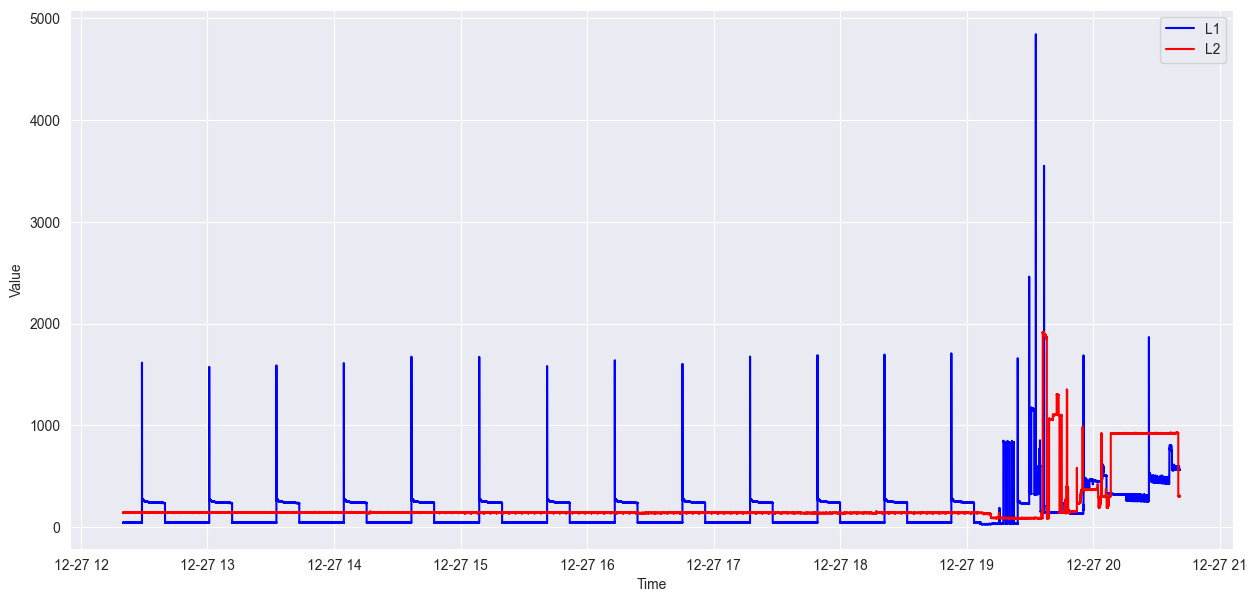

In [112]:
start_index, end_index = zoomIn("2012-12-27 12:20:00", "2012-12-27 20:41:10", time_ticks1_np)
plt.figure(figsize=(15, 7))

# This plots phase 1 and phase 2 separately (zoomed in)
plt.plot(TS1_real[start_index:end_index], L1_actual_power[start_index:end_index], linestyle='-', color='b', label='L1')
plt.plot(TS2_real[start_index:end_index], L2_actual_power[start_index:end_index], linestyle='-', color='r', label='L2')

plot_events(phase1, start_index, end_index, TS1_real)

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

9


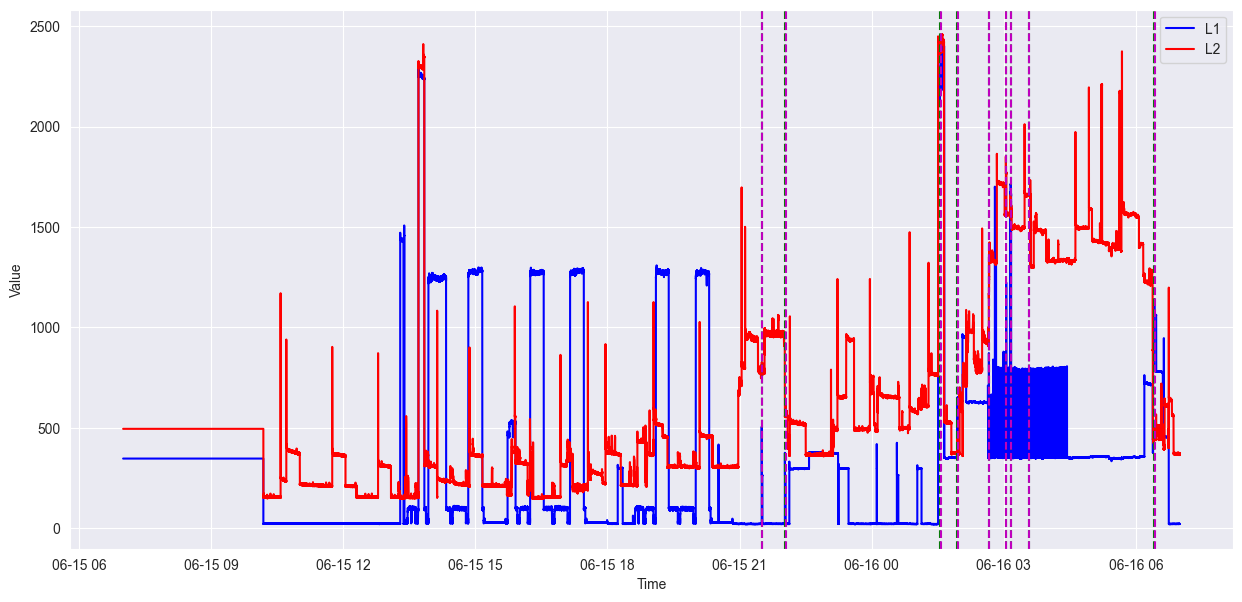

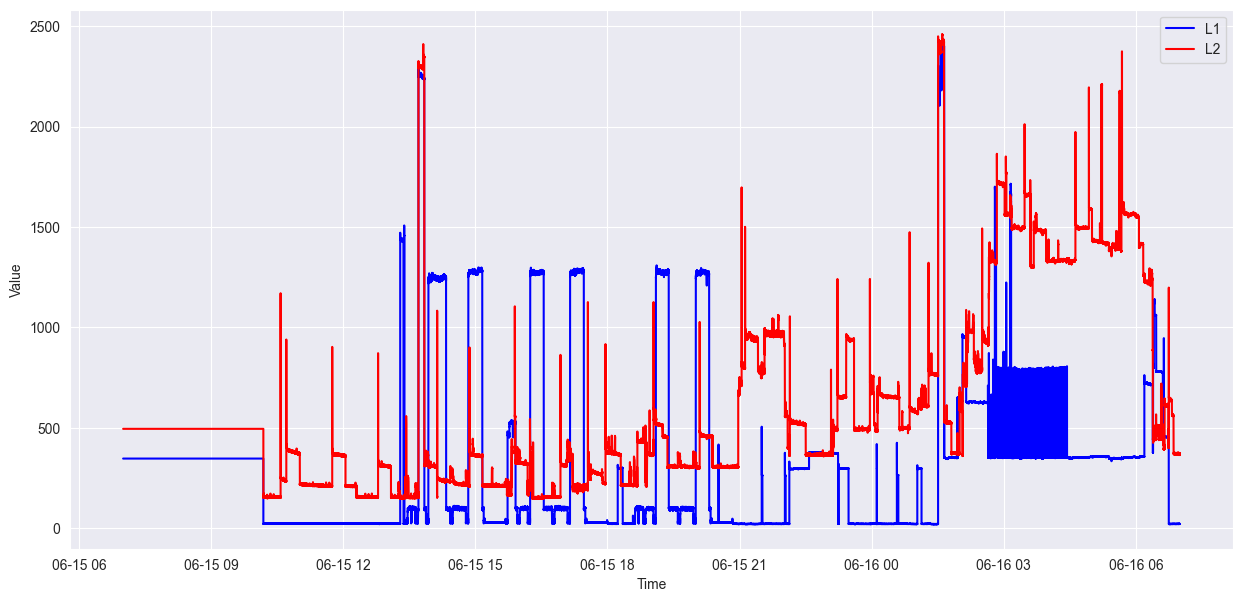

ValueError: x and y must have same first dimension, but have shapes (518922,) and (518943,)

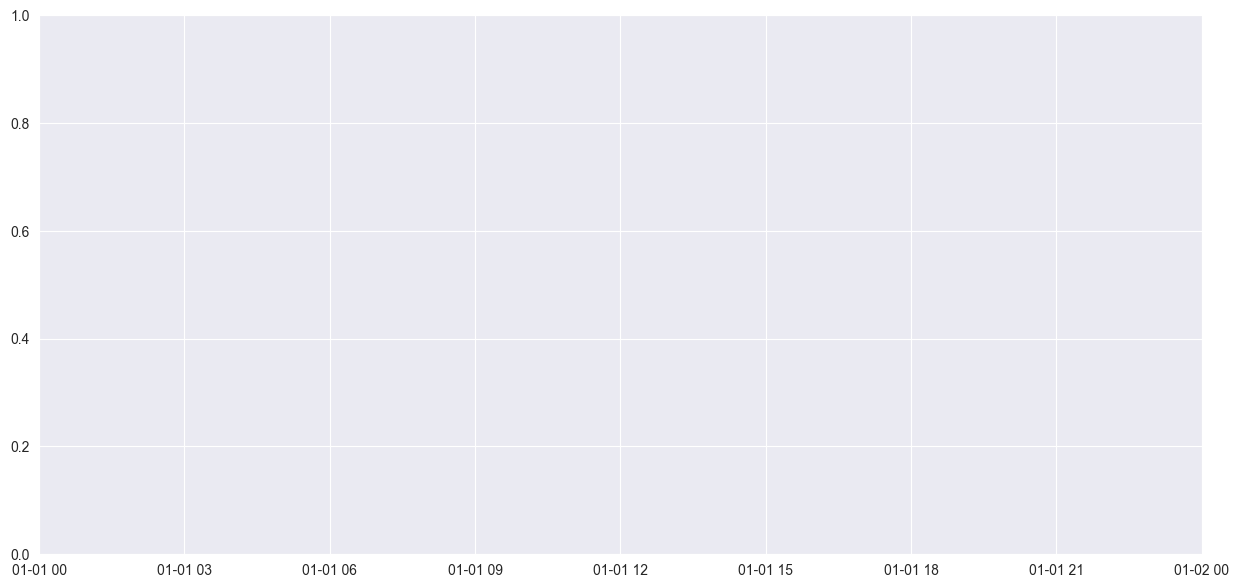

In [310]:
plt.figure(figsize=(15, 7))
plt.plot(TS1_real, L1_actual_power, linestyle='-', color='b', label='L1')
plt.plot(TS2_real, L2_actual_power, linestyle='-', color='r', label='L2')
event_times = [TS1_real[i] for i in clean_events_start]
print(len(event_times))
for event_time in event_times:
    plt.axvline(event_time, color='g', linestyle='--')

event_times = [TS1_real[i] for i in clean_events_end]
for event_time in event_times:
    plt.axvline(event_time, color='m', linestyle='--')
# plt.plot(TS1_real, power, linestyle='-', color='r', label='power')

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 7))
plt.plot(TS1_real, L1_actual_power, linestyle='-', color='b', label='L1')
plt.plot(TS2_real, L2_actual_power, linestyle='-', color='r', label='L2')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 7))
plt.plot(TS1_real, power, linestyle='-', color='b', label='L1')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Working on the model

###

In [83]:
normalized_phase1 = normalize(L1_actual_power)
normalized_phase2 = normalize(L2_actual_power)

###